# NIFITS: application to NOTT

## Perimeter
This work serves as a an exploration proof of concept to demonstrate how NIFITS models can operate with a spatial filtered photonics nuller with a double-bracewell combination.

In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it.
from IPython.core.display import HTML
css_file = '/home/romain/Downloads/numericalmoocstyle.css'
HTML(open(css_file, 'r').read())

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as units
from astropy.table import Table

### Creation of the VLTI NOTT array
The pupil map is created based on data provided by the consortium. It was built for the example and should not serve as reference.

In [3]:
import scifysim as sf
from scifysim.dummy import makesim

Building a model from scratch
ERROR-scifysim.utilities- Couldn't find the entry in JSDC catalog
Dist set to  10.786997784350653 [pc]
T set to  5263.5 [K]
R set to  0.77 [R_sun]
WARNING-scifysim.director- tt_correction not implemented
WARNING-scifysim.director- no_piston not implemented
ERROR-scifysim.injection- Now we use fpath to provide the root for appendix config files
WARNING-scifysim.injection- Using same file for atmo configuration
0.010342691863670104
WARNING-scifysim.injection- Loading keyword step_time from [atmo] in fringe_tracking
WARNING-scifysim.injection- Preparing a fringe tracking residual time series
WARNING-scifysim.injection- Dry pistons and dispersion residuals scaling refreshed
sep =  4.5
pa =  60.0
offset =  (-3.8971143170299736, 2.2500000000000004)
WARNING-scifysim.combiner- Comuputed chromatic combiner matrix with the following shape:
WARNING-scifysim.combiner- (9, 8, 4)
----------------------------------------
Switching to znse+co2
ERROR-scifysim.director- Cor

In [4]:
asim = makesim("/home/romain/Documents/hi5/SCIFYsim/scifysim/config/default_R400.ini",
               target="Gl 86A")

from kernuller import pairwise_kernel
ak = pairwise_kernel(2)
myk = np.hstack((np.zeros((1,3)), ak, np.zeros((1,3))))
asim.combiner.K = myk
del ak
del myk


ERROR-scifysim.utilities- Couldn't find the entry in JSDC catalog
Dist set to  10.786997784350653 [pc]
T set to  5263.5 [K]
R set to  0.77 [R_sun]
WARNING-scifysim.director- tt_correction not implemented
WARNING-scifysim.director- no_piston not implemented
ERROR-scifysim.injection- Now we use fpath to provide the root for appendix config files
WARNING-scifysim.injection- Using same file for atmo configuration
0.010342691863670104
WARNING-scifysim.injection- Loading keyword step_time from [atmo] in fringe_tracking
WARNING-scifysim.injection- Preparing a fringe tracking residual time series
WARNING-scifysim.injection- Dry pistons and dispersion residuals scaling refreshed
sep =  4.5
pa =  60.0
offset =  (-3.8971143170299736, 2.2500000000000004)
WARNING-scifysim.combiner- Comuputed chromatic combiner matrix with the following shape:
WARNING-scifysim.combiner- (67, 8, 4)
----------------------------------------
Switching to znse+co2
ERROR-scifysim.director- Correcting with only ZnSe and CO

## Phasing and beam-combination information

In NOTT, the beam-combiner has static chromatic effects that are encoded into the `Mcn` datacube containing the beam-cobination matrix for each wavelength. This effect is compensated by an LDC static offset, which effect is stored in `g_internal`.

The leftovers from the atmospheric dispersion, conpensated with the LDC is stored in `g_atmo`.

Following the NIFITS guideline, we set aside the static contribution of `g_internal` to be factored into the beam-combiner matrix `NI_CATM`. The effects of `g_atmo` are added to 

<div class="alert alert-block alert-warning">
<b>TODO:</b> In practice, the choice of beam-combiner mode (i.e. planet vs disk mode) should fall under NI_MOD vector. But in the current setup of SCIFYsim, it would still be contained in `g_internal`, which would mean a different `NI_CATM` matrix if nothing is done. This is not very critical as long as `NI_CATM` is close.
</div>

/lhome/romain/miniconda3/envs/path/lib/python3.9/site-packages/matplotlib/transforms.py:2855: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
/home/romain/Documents/kernel/kernuller/kernuller/diagrams.py:408: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


removing the labels: [False False False False False False False False]


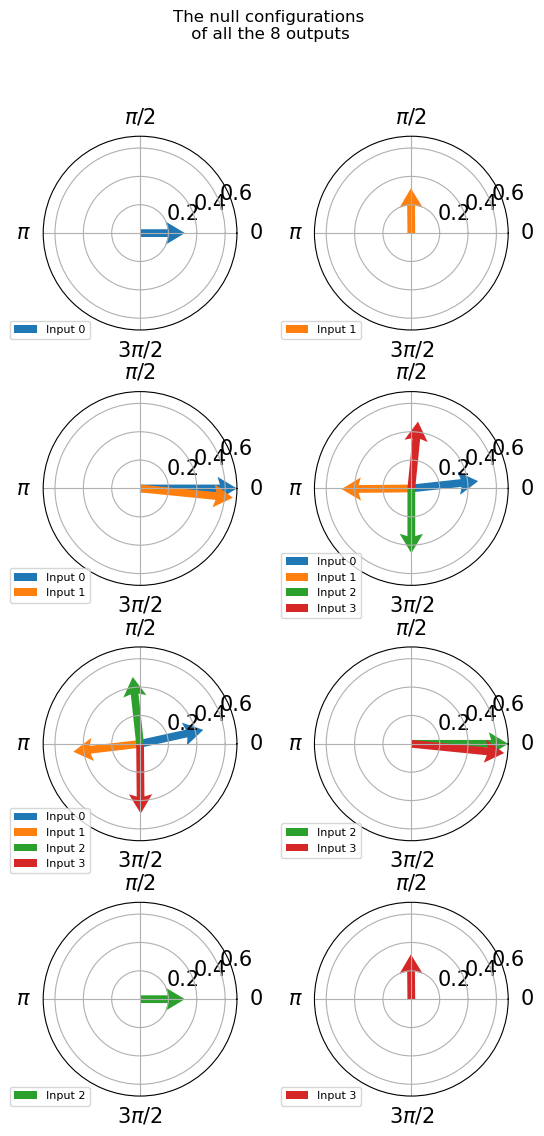

/tmp/ipykernel_19104/3628459892.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
/tmp/ipykernel_19104/3628459892.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


(6, 12.5)
(6, 12.5)
out_switch (67, 8, 4)
inarray (67, 4)



/tmp/ipykernel_19104/3628459892.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig3.show()


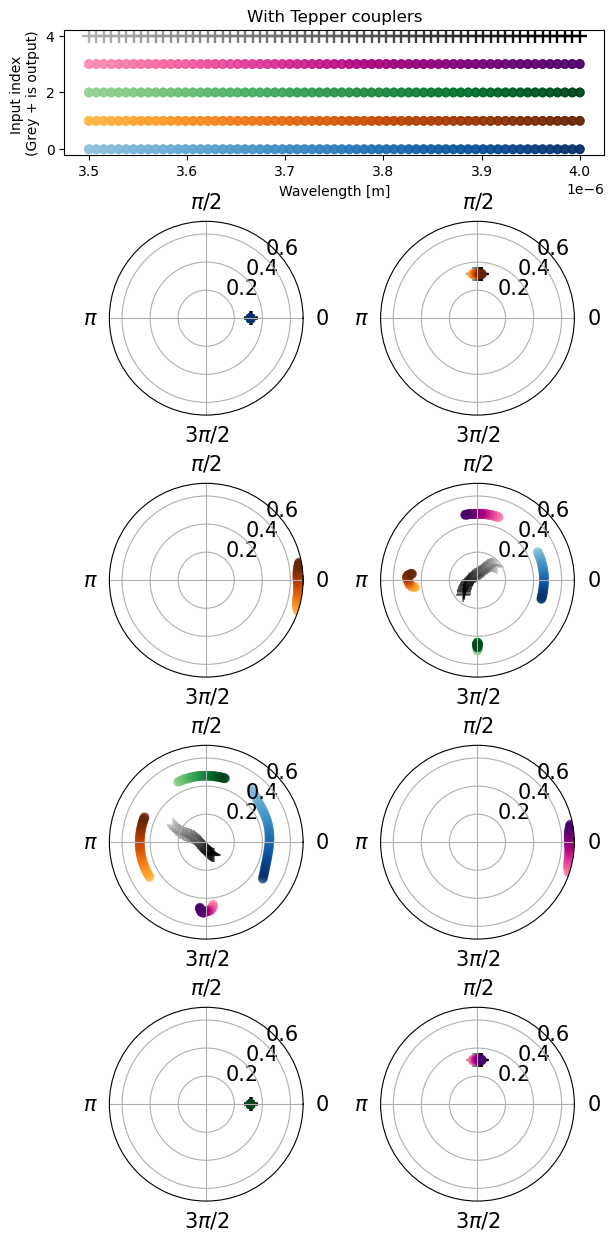

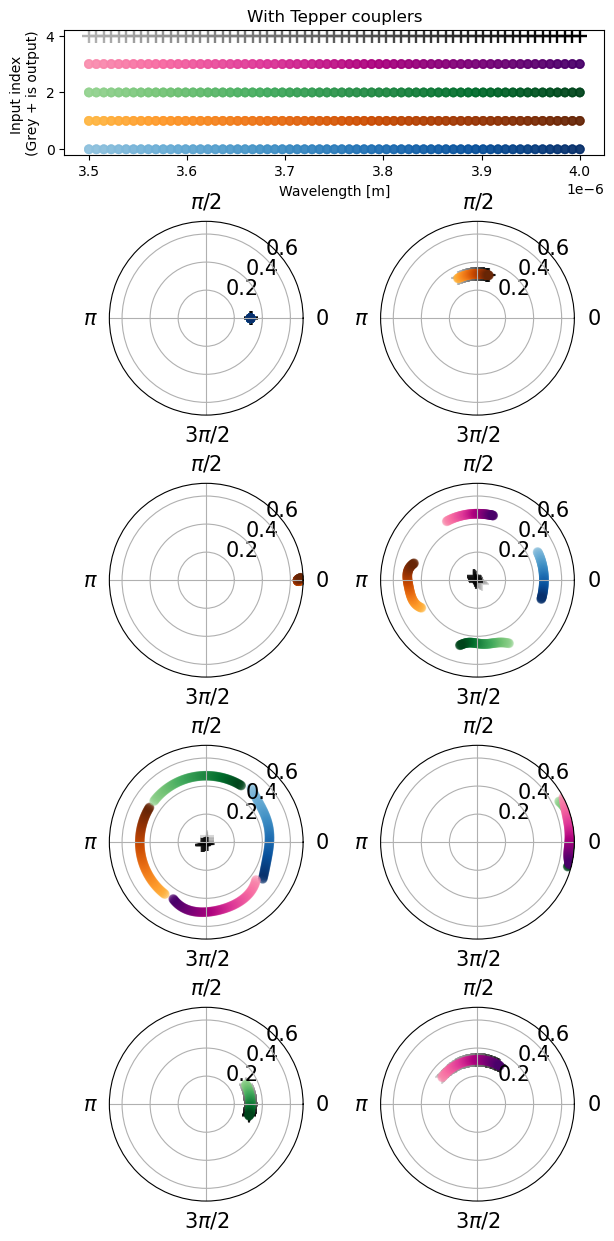

In [5]:
from kernuller.diagrams import plot_chromatic_matrix, plot_outputs_smart
# asim.combiner = sf.combiner.combiner.from_config(asim.config, ph_shifters=(0,-np.pi/2))
# asim.combiner.chromatic_matrix(asim.lambda_science_range)
# asim.point(asim.sequence[10], asim.target, refresh_array=True)

asim.point(asim.sequence[0], asim.target)
g_atmo = asim.offband_model.get_phase_science_values(asim.pistons)
g_internal = asim.corrector.get_phasor(asim.lambda_science_range)
# plt.plot(asim.lambda_science_range, g_atmo)
# plt.plot(asim.lambda_science_range, g_internal)
Mcnc = asim.combiner.Mcn*g_internal[:,None,:]

fig1, axs = plot_outputs_smart(matrix = asim.combiner.Mcn[30])
fig1.show()
fig2, axs, matrix = plot_chromatic_matrix(asim.combiner.M,
                                         sf.combiners.lamb, asim.lambda_science_range,
                                         verbose=False, returnmatrix=True,minfrac=0.9,
                                         plotout=True, show=False, title="With Tepper couplers")
fig2.show()
fig3, axs, matrix = plot_chromatic_matrix(asim.combiner.M,
                                         sf.combiners.lamb, asim.lambda_science_range,
                                         verbose=False, returnmatrix=True,minfrac=0.9,
                                         plotout=g_internal, show=False, title="With Tepper couplers")
fig3.show()

Using loc_array [[ 0. 10.]
 [10.  0.]]


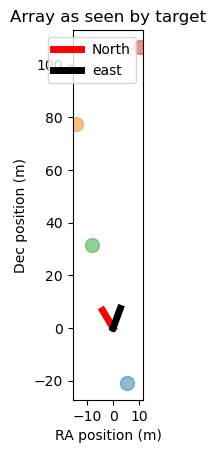

In [6]:
fig = sf.plot_tools.plot_projected_pupil(asim, 0, perspective=False, usize=200)
# plt.sca(fig.axes[0])
# plt.xlim(-20, 20)
# plt.legend(fontsize=7)
# plt.show()

In [156]:
from astropy.table import Table
from astropy import units
class nott_nifits(object):
    def __init__(self, asim):
        self.missing = [] # To contain missing elements for TODO list

        # The OI_WAVELENGTH
        self.OI_WAVELENGTH_EFF_WAVE = asim.lambda_science_range
        self.OI_WAVELENGTH_EFF_BAND = np.gradient(self.OI_WAVELENGTH_EFF_WAVE)
        
        # The OI_ARRAY
        if isinstance(asim.obs, sf.observatory.observatory):
            self.OI_ARRAY_frame = "geocentric"
            self.OI_ARRAY_location = asim.obs.observatory_location
        elif isinstance(asim.obs, sf.observatory.ObservatoryAltAz):
            self.OI_ARRAY_frame = "altaz"
            self.OI_ARRAY_location = asim.obs.observatory_location
        elif isinstance(asim.obs, sf.observatory.SpaceObservatory):
            self.OI_ARRAY_frame = "None"
            self.missing.append("Observatory location for space")
        
        self.OI_ARRAY = asim.obs.statlocs
        self.OI_ARRAY_name = asim.config.get("configuration", "config")
        array_table = Table(names=["TEL_NAME", "STA_NAME", "STA_INDEX", "DIAMETER", "STAXYZ", "FOV", "FOVTYPE"],
              dtype=[str, str, int, float, np.ndarray, float, str])
        for i in np.arange(asim.obs.statlocs.shape[0]):
            print(f"Telescope{i}")
            anxy = asim.obs.statlocs[i]
            if asim.obs.statlocs[i].shape[0] == 2:
                anxyz = np.append(anxy, np.zeros(1), axis=0)
            else:
                anxyz = asim.obs.statlocs[i]
            fov = asim.lambda_science_range.mean()/asim.obs.pdiams[i]*units.rad.to(units.mas)
            array_table.add_row(vals=[f"Tel{i}", f"Sta{i}", i, asim.obs.pdiams[i], anxyz , fov, "RADIUS"])
        self.OI_ARRAY_table = array_table
        
        # self.array = asim.obs.get_projected_array()
        self.g_atmo = asim.offband_model.get_phase_science_values(asim.pistons)
        self.g_internal = asim.corrector.get_phasor(asim.lambda_science_range)
        self.Mcn = asim.combiner.Mcn*self.g_internal[:,None,:]
        self.missing.append("PERFECT INJECTION")
        self.throughput = asim.src.sky.get_downstream_transmission(asim.lambda_science_range, )
        self.NI_MOD = self.throughput[:,None] * np.exp(1j*self.g_atmo)

        # The NI_CATM
        self.NI_CATM = self.Mcn

        # The NI_KMAT
        self.NI_KMAT = asim.combiner.K
        
    def add_ni_mod(self, asim, target_id=1, int_time=1.):
        if not hasattr(self, "NI_MOD_table"):
            self.NI_MOD_table = Table (names=["TARGET_ID", "TIME", "MJD", "INT_TIME","MOD_PHAS" , "APPXY", "ARRCOL"],
                                    units=[None, units.s, units.day, units.s, None , units.m, units.m**2],
                                     dtype=[int, float, float, float, np.ndarray,  np.ndarray, float])
        xys = asim.obs.get_projected_array()
        allmods = self.throughput[:,None] * np.exp(1j*self.g_atmo)
        for i in np.arange(xys.shape[0]):
            self.NI_MOD_table.add_row([target_id, asim.obs.time.to_value("unix"), asim.obs.time.to_value("mjd"),
                                         int_time, allmods[:,i], xys[i], asim.injector.collecting])
            
    def add_ni_out(self, asim, ni_out=None, ni_mod=None, ni_vout=None,
                      target_id=1, int_time=1.):
        # General keywords:
        asim.DATE_OBS = asim.obs.time.isot

        # self.NI_MOD = asim.obs.get_projected_array()
        self.add_ni_mod(asim, target_id=target_id, int_time=int_time)
        
        # The NI_MOD
        if ni_mod is None:
            self.NI_MOD = ni_mod
        else:
            self.g_atmo = asim.offband_model.get_phase_science_values(asim.pistons)
            self.throughput = asim.src.sky.get_downstream_transmission(asim.lambda_science_range, )
            self.NI_MOD = self.throughput[:,None] * np.exp(1j*self.g_atmo)
            
        # The NI_OUT (main data)
        self.NI_OUT = ni_out
        self.NI_VOUT = ni_vout

    def add_ni_k(self, asim, ni_kout=None, ni_kcov=None):
        self.NI_KOUT = ni_kout
        self.NI_KCOV = ni_kcov

    def get_modulation_phasor(self):
        """
        Computes and returns the modulation phasor [n_wl, n_input]
        """
        mods = np.array([a  for a in self.NI_MOD_table["MOD_PHAS"]]).T
        return mods

    def geometric_phasor(self, alpha, beta, include_mod=True):
        """
        Returns the complex phasor corresponding to the locations
        of the family of sources
        
        **Parameters:**
        
        * alpha         : The coordinate matched to X in the array geometry
        * beta          : The coordinate matched to Y in the array geometry
        * anarray       : The array geometry (n_input, 2)
        * include_mod   : Include the modulation phasor
        
        **Returns** : A vector of complex phasors
        """
        xy_array = np.vstack(self.NI_MOD_table["APPXY"])
        k = 2*np.pi/self.OI_WAVELENGTH_EFF_WAVE
        a = np.array((alpha, beta), dtype=np.float64)
        phi = k[:,None,None] * xy_array.dot(a)[None,:]
        b = np.exp(1j*phi)
        if include_mod:
            mods = self.get_modulation_phasor()
            b *= mods[:,:,None]
        return b
        
    def get_Is(self, xs):
        E = np.einsum("w o i , w i m -> w o m", self.NI_CATM, xs)
        I = np.abs(E)**2
        return I

    def get_KIs(self, I):
        KI = np.einsum("w i m, o i -> w o m", I, self.NI_KMAT[:,:])
        return KI
        
        
    def dot_all_fov(self,  xs):
        I = self.get_Is(xs)
        KI = self.get_KIs(I)
        return KI
        
    def get_all_ks(self, alphas, betas):
        xs = self.geometric_phasor(alphas, betas)
        KIs = self.dot_all_fov(xs)
        return KIs
        
        
    

In [157]:
annifits = nott_nifits(asim)

Telescope0
Telescope1
Telescope2
Telescope3


In [128]:
asim.point(asim.sequence[0], asim.target, )
aseq = []
for i in range(10):
    myint = asim.make_exposure(asim.src.planet, asim.src.star, asim.diffuse, texp=1.)
    aseq.append(myint.get_total(n_pixsplit=8.0))
    myint.reset
aseq = np.array(aseq)
akseq = np.einsum("k o, t w o -> t w k", asim.combiner.K, aseq)
obs_mean = np.mean(aseq, axis=0)
obs_std= np.std(aseq, axis=0)
kobs_mean = np.mean(akseq, axis=0)
kobs_std= np.std(akseq, axis=0)
kobs_cov = np.cov(akseq.reshape(akseq.shape[0], -1).T)

WARNING-scifysim.director- Currently no vigneting (requires a normalization of vigneting)
WARNING-scifysim.director- Ugly management of injection/tracking
WARNING-scifysim.spectrograph- Usin post-defined n_pixsplit
WARNING-scifysim.director- Currently no vigneting (requires a normalization of vigneting)
WARNING-scifysim.director- Ugly management of injection/tracking
WARNING-scifysim.spectrograph- Usin post-defined n_pixsplit
WARNING-scifysim.director- Currently no vigneting (requires a normalization of vigneting)
WARNING-scifysim.director- Ugly management of injection/tracking
WARNING-scifysim.spectrograph- Usin post-defined n_pixsplit
WARNING-scifysim.director- Currently no vigneting (requires a normalization of vigneting)
WARNING-scifysim.director- Ugly management of injection/tracking
WARNING-scifysim.spectrograph- Usin post-defined n_pixsplit
WARNING-scifysim.director- Currently no vigneting (requires a normalization of vigneting)
WARNING-scifysim.director- Ugly management of inje

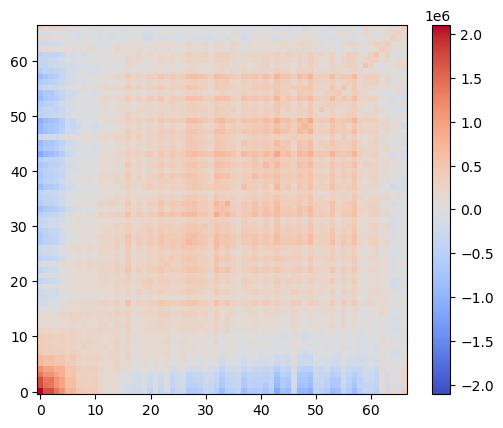

In [158]:
plt.figure()
plt.imshow(kobs_cov, cmap="coolwarm", vmin=-np.max(kobs_cov), vmax=np.max(kobs_cov))
plt.colorbar()
plt.show()

In [159]:
annifits.add_ni_out(asim, ni_out=obs_mean, ni_mod=None, ni_vout=obs_std**2, 
                   target_id=1, int_time=1.)
annifits.add_ni_k(asim, ni_kout=kobs_mean, ni_kcov=kobs_cov)

In [160]:
annifits.OI_ARRAY_table

TEL_NAME,STA_NAME,STA_INDEX,DIAMETER,STAXYZ,FOV,FOVTYPE
str4,str4,int64,float64,object,float64,str6
Tel0,Sta0,0,8.0,[ -9.925 -20.335 0. ],96.6866279283264,RADIUS
Tel1,Sta1,1,8.0,[44.915 66.183 0. ],96.6866279283264,RADIUS
Tel2,Sta2,2,8.0,[14.887 30.502 0. ],96.6866279283264,RADIUS
Tel3,Sta3,3,8.0,[103.306 44.999 0. ],96.6866279283264,RADIUS


In [161]:

annifits.NI_MOD_table

TARGET_ID,TIME,MJD,INT_TIME,MOD_PHAS,APPXY,ARRCOL
,s,d,s,,m,m2
int64,float64,float64,float64,object,object,float64
1,1603152000.0,59142.0,1.0,[0.04516628+6.05339630e-05j 0.04587088+4.98281089e-05j 0.04609829+3.57122893e-05j 0.04658507+3.03914716e-05j 0.04446175+2.04310858e-05j 0.04009867+1.38983134e-05j 0.04209508+9.06353498e-06j 0.04312801+1.75742799e-06j 0.04523111-8.83084283e-07j 0.04107793-3.88902055e-06j 0.04173914-8.75111674e-06j 0.04162407-1.03306071e-05j 0.0426679 -1.51854720e-05j 0.0446826 -1.79691466e-05j 0.0436675 -1.85431230e-05j 0.04364551-1.96898851e-05j 0.04661 -2.36879831e-05j 0.04386779-2.05569439e-05j 0.04622825-2.35804103e-05j 0.0453698 -2.18652726e-05j 0.04546535-2.25016853e-05j 0.04745104-2.39640088e-05j 0.04449238-2.46526717e-05j 0.03792269-1.86062914e-05j 0.04444271-1.83295789e-05j 0.04528078-1.80081427e-05j 0.04724559-1.71407336e-05j 0.04747222-2.39176396e-05j 0.04452609-2.19779194e-05j 0.04691939-2.11941923e-05j 0.0459864 -2.00892745e-05j 0.04421444-1.55920589e-05j 0.04606743-1.54655464e-05j 0.04576736-9.63822965e-06j 0.04476803-8.18283776e-06j 0.04514373-4.74336294e-06j 0.04487491-1.92470857e-06j 0.04595978+2.76312474e-06j 0.04336679+2.25322422e-06j 0.0449362 +4.37861412e-06j 0.04612684+9.21850461e-06j 0.04352347+1.01639759e-05j 0.04515293+1.34560509e-05j 0.04626631+1.81174111e-05j 0.04439819+1.74166912e-05j 0.04481462+1.78092118e-05j 0.04433034+1.88987706e-05j 0.04388252+2.24086136e-05j 0.04208828+2.26203923e-05j 0.03865866+2.28298176e-05j 0.03629309+2.23617088e-05j 0.03621405+2.12573968e-05j 0.0384405 +2.51971488e-05j 0.04182148+2.36176184e-05j 0.03857178+2.34738414e-05j 0.03722331+1.95031640e-05j 0.03712097+1.42451957e-05j 0.03853002+1.02394372e-05j 0.03954372+1.04625793e-05j 0.04061884+3.73343132e-06j 0.04086256+2.16667909e-06j 0.04100768-2.99929205e-06j 0.04083443-1.26025257e-05j 0.03985402-1.44856184e-05j 0.03957778-2.58643278e-05j 0.0390833 -2.89726380e-05j 0.03842522-4.07563242e-05j],[ 5.39772995 -20.89275845],49.28730360244436
1,1603152000.0,59142.0,1.0,[0.04516614-1.28692224e-04j 0.04587078-1.05932073e-04j 0.04609824-7.59226646e-05j 0.04658504-6.46108978e-05j 0.04446174-4.34355327e-05j 0.04009866-2.95473187e-05j 0.04209508-1.92685635e-05j 0.04312801-3.73639782e-06j 0.04523111+1.87759125e-06j 0.04107793+8.26793492e-06j 0.04173914+1.86042497e-05j 0.04162407+2.19622211e-05j 0.04266789+3.22837901e-05j 0.04468259+3.82013702e-05j 0.04366749+3.94219360e-05j 0.04364549+4.18598546e-05j 0.04660998+5.03593778e-05j 0.04386777+4.37032000e-05j 0.04622823+5.01310796e-05j 0.04536978+4.64846242e-05j 0.04546533+4.78373796e-05j 0.04745102+5.09462827e-05j 0.04449235+5.24104976e-05j 0.03792267+3.95560184e-05j 0.0444427 +3.89680828e-05j 0.04528077+3.82845562e-05j 0.04724558+3.64402886e-05j 0.0474722 +5.08479883e-05j 0.04452607+4.67239819e-05j 0.04691937+4.50577183e-05j 0.04598638+4.27088574e-05j 0.04421443+3.31478543e-05j 0.04606742+3.28791502e-05j 0.04576736+2.04906624e-05j 0.04476803+1.73962048e-05j 0.04514373+1.00839389e-05j 0.04487491+4.09188118e-06j 0.04595978-5.87424555e-06j 0.04336679-4.79023454e-06j 0.0449362 -9.30865230e-06j 0.04612684-1.95979197e-05j 0.04352347-2.16079677e-05j 0.04515292-2.86069813e-05j 0.0462663 -3.85166882e-05j 0.04439818-3.70270644e-05j 0.04481461-3.78617413e-05j 0.04433033-4.01779186e-05j 0.0438825 -4.76397907e-05j 0.04208826-4.80898125e-05j 0.03865863-4.85351885e-05j 0.03629307-4.75399038e-05j 0.03621403-4.51922221e-05j 0.03844047-5.35681706e-05j 0.04182146-5.02100327e-05j 0.03857175-4.99043716e-05j 0.0372233 -4.14628182e-05j 0.03712096-3.02844898e-05j 0.03853002-2.17687250e-05j 0.03954372-2.22428383e-05j 0.04061884-7.93699451e-06j 0.04086256-4.60629822e-06j 0.04100768+6.37644342e-06j 0.04083442+2.67922242e-05j 0.03985401+3.07957413e-05j 0.03957775+5.49863088e-05j 0.03908326+6.15944753e-05j 0.03842515+8.66461364e-05j],[-14.12088392 77.38570268],49.28730360244436
1,1603152000.0,59142.0,1.0,[0.04516623-9.08007776e-05j 0.04587085-7.47418880e-05j 0.04609827-5.35684200e-05j 0.04658506-4

In [162]:
annifits.__dict__

{'missing': ['PERFECT INJECTION'],
 'OI_WAVELENGTH_EFF_WAVE': array([3.50000000e-06, 3.50757576e-06, 3.51515152e-06, 3.52272727e-06,
        3.53030303e-06, 3.53787879e-06, 3.54545455e-06, 3.55303030e-06,
        3.56060606e-06, 3.56818182e-06, 3.57575758e-06, 3.58333333e-06,
        3.59090909e-06, 3.59848485e-06, 3.60606061e-06, 3.61363636e-06,
        3.62121212e-06, 3.62878788e-06, 3.63636364e-06, 3.64393939e-06,
        3.65151515e-06, 3.65909091e-06, 3.66666667e-06, 3.67424242e-06,
        3.68181818e-06, 3.68939394e-06, 3.69696970e-06, 3.70454545e-06,
        3.71212121e-06, 3.71969697e-06, 3.72727273e-06, 3.73484848e-06,
        3.74242424e-06, 3.75000000e-06, 3.75757576e-06, 3.76515152e-06,
        3.77272727e-06, 3.78030303e-06, 3.78787879e-06, 3.79545455e-06,
        3.80303030e-06, 3.81060606e-06, 3.81818182e-06, 3.82575758e-06,
        3.83333333e-06, 3.84090909e-06, 3.84848485e-06, 3.85606061e-06,
        3.86363636e-06, 3.87121212e-06, 3.87878788e-06, 3.88636364e-06,
   

In [163]:

map_fov_mas = 15.
map_res = 105
mas2rad = units.mas.to(units.rad) # in mas
aa, bb = np.meshgrid(np.linspace(-map_fov_mas, map_fov_mas, map_res), np.linspace(-map_fov_mas, map_fov_mas, map_res))
map_extent=[np.min(aa), np.max(aa), np.min(aa), np.max(aa)]
all_KIs = annifits.get_all_ks(mas2rad * aa.flatten(), mas2rad * bb.flatten())
all_KIs = all_KIs.reshape((all_KIs.shape[0], all_KIs.shape[1], *aa.shape))


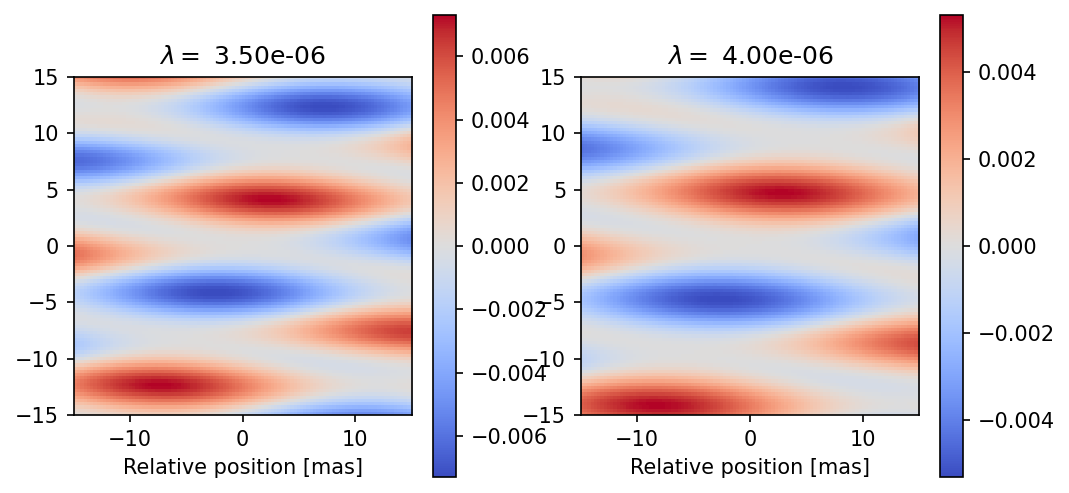

In [164]:
plt.figure(dpi=150, figsize=(8,4))
plt.subplot(121)
plt.imshow(all_KIs[0,0,:,:], cmap="coolwarm", extent=map_extent)
plt.colorbar()
plt.title(f"$\\lambda=$ {annifits.OI_WAVELENGTH_EFF_WAVE[0]:.2e}")
plt.xlabel("Relative position [mas]")
plt.subplot(122)
plt.imshow(all_KIs[-1,0,:,:], cmap="coolwarm", extent=map_extent)
plt.colorbar()
plt.title(f"$\\lambda=$ {annifits.OI_WAVELENGTH_EFF_WAVE[-1]:.2e}")
plt.xlabel("Relative position [mas]")
plt.show()

def geometric_phasor(alpha, beta, anarray, lambs):
    """
    Returns the complex phasor corresponding to the locations
    of the family of sources
    
    **Parameters:**
    
    * alpha         : The coordinate matched to X in the array geometry
    * beta          : The coordinate matched to Y in the array geometry
    * anarray       : The array geometry (n_input, 2)
    
    **Returns** : A vector of complex phasors
    """
    k = 2*np.pi/lambs
    a = np.array((alpha, beta), dtype=np.float64)
    phi = k[:,None,None] * anarray.dot(a)[None,:]
    b = np.exp(1j*phi)
    return b
def dot_all_fov(C, xs, K):
    E = np.einsum("w o i , w i m -> w o m", C, xs)
    I = np.abs(E)**2
    kap = np.einsum("w i m, o i -> w o m", I, K[:,:])
    return kap